In [1]:
from data_processing import *
from train_classifier import *
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

In [2]:
# FULL_DATA = pd.read_csv('features/motif_unnormed_expression_families_conservativity_cage_dnase_blocks.tsv', sep='\t')
# del FULL_DATA['mz46_pre']
# del FULL_DATA['mz100_pre']
# FULL_DATA = filter_features_by_type(FULL_DATA, ['median_pval', 'median_abs_fc'])

# FULL_DATA = pd.read_csv('features/old/motif_features_combined_respresentatives.tsv', sep='\t')
FULL_DATA = pd.read_csv('features/motif_unnormed_expression_families.tsv', sep='\t')
pval_feature_suffix = 'pval_1_best'
fc_feature_suffix = 'fc_samepos'
FULL_DATA = filter_features_by_type(FULL_DATA, [pval_feature_suffix, fc_feature_suffix])

motif_pval_feature_names = feature_names_by_type(FULL_DATA, pval_feature_suffix)
motif_pval_feature_names.sort()
motif_fc_feature_names = feature_names_by_type(FULL_DATA, fc_feature_suffix)
motif_fc_feature_names.sort()

num_motifs = len(motif_pval_feature_names)

In [3]:
ones = tf.ones(shape=(1,num_motifs,), dtype=tf.float64)

# here initial values are fictive
thresholds = tf.Variable(dtype=tf.float64, expected_shape=(num_motifs,), initial_value=ones, name='thresholds')
weights = tf.Variable(dtype=tf.float64, expected_shape=(num_motifs,), initial_value=ones, name='weights')
sigma = tf.Variable(dtype=tf.float64, expected_shape=(num_motifs,), initial_value=ones, name='sigma')

t_0 = tf.Variable(dtype=tf.float64, initial_value=3.8, name='t_0')
w_0 = tf.Variable(dtype=tf.float64, initial_value=1.0, name='w_0')
s_0 = tf.Variable(dtype=tf.float64, initial_value=1.0, name='s_0')

pvals = tf.placeholder(tf.float64, shape=(None, num_motifs,), name='pvals')
fcs = tf.placeholder(tf.float64, shape=(None, num_motifs,), name='fcs')
confs = tf.placeholder(tf.float64, shape=(None, ), name='confs')

sess = tf.Session()

In [4]:
# sess.run(w_0.assign(1.0 / num_motifs)) # for sum
# sess.run(w_0.assign(1.0)) # for max
sess.run(w_0.assign(0.3))

sess.run(t_0.assign(3.6))
sess.run(s_0.assign(1.25))

sess.run(sigma.assign(ones * s_0))
sess.run(thresholds.assign(t_0 * ones))
sess.run(weights.assign(w_0 * ones))
print()

In [6]:
activation_scores = tf.sigmoid(sigma * (pvals - thresholds)) * tf.abs(fcs) * tf.abs(weights)
prediction = tf.reduce_max(activation_scores, axis=1)
# # prediction = tf.sigmoid(tf.reduce_sum(activation_scores, axis=1))

In [5]:
# Alternative loss (constant weights/thresholds etc)
activation_scores = tf.sigmoid((s_0 * ones) * (pvals - t_0 * ones)) * tf.abs(fcs) * tf.abs(w_0 * ones)
prediction = tf.reduce_max(activation_scores, axis=1)

In [6]:
prediction_error = prediction - confs
samples_loss    = tf.reduce_sum(tf.square(prediction_error))

thresholds_loss = tf.reduce_sum(tf.square(thresholds - t_0 * ones))
weights_loss    = tf.reduce_sum(tf.square(weights    - w_0 * ones))
sigma_loss      = tf.reduce_sum(tf.square(sigma      - s_0 * ones))

C_thresholds = 1.0
C_weights = 1.0
C_sigma = 1.0

# C_thresholds = 0.0
# C_weights = 0.0
# C_sigma = 0.0

loss = samples_loss + C_thresholds * thresholds_loss + C_weights * weights_loss + C_sigma * sigma_loss

step_info = {
    't_0': t_0, 'w_0': w_0, 's_0': s_0,
    'samples_loss': samples_loss,
    'thresholds_loss': thresholds_loss, 'weights_loss': weights_loss, 'sigma_loss': sigma_loss,
#     'thresholds': thresholds, 'weights': weights, 'sigma': sigma,
#     'prediction': prediction,
    'loss': (loss, samples_loss, thresholds_loss, weights_loss, sigma_loss),
}
values_to_report = [
    't_0', 'w_0', 's_0',
    'samples_loss', 'thresholds_loss', 'weights_loss', 'sigma_loss',
]

In [19]:
optimizer = tf.train.GradientDescentOptimizer(0.0001)
train = optimizer.minimize(loss)

In [20]:
num_constructions = len(CONSTRUCTONS)
aucs = [[None for j in range(num_constructions)] for i in range(num_constructions)]
ml_config = [[None for j in range(num_constructions)] for i in range(num_constructions)]
for train_idx in range(num_constructions):
    train_construction = CONSTRUCTONS[train_idx]

    train_data = FULL_DATA[ FULL_DATA['construction'] == train_construction]
#     print(train_data)
    train_feed_data = {
        pvals: train_data[motif_pval_feature_names],
        fcs: train_data[motif_fc_feature_names], 
        confs: train_data[['confidence']].as_matrix().flatten(),
    #     confs: (1.0 * train_data[['confidence']] > 0.1).as_matrix().flatten(),
    }

    sess.run(w_0.assign(0.3))
    sess.run(t_0.assign(3.6))
    sess.run(s_0.assign(1.25))

    sess.run(sigma.assign(ones * s_0))
    sess.run(thresholds.assign(t_0 * ones))
    sess.run(weights.assign(w_0 * ones))

    for i in range(1001):
        train_feed_data_subset = train_feed_data
        sess.run(train, feed_dict=train_feed_data_subset)

    last_step, lossval = sess.run((step_info, loss), feed_dict=train_feed_data)
    ml_config[train_idx] = last_step
    
    for test_idx in range(num_constructions):
        test_construction = CONSTRUCTONS[test_idx]
        test_data = FULL_DATA[FULL_DATA['construction'] == test_construction]
        test_feed_data = {
            pvals: test_data[motif_pval_feature_names],
            fcs: test_data[motif_fc_feature_names]
        }
        scores = sess.run(prediction, feed_dict=test_feed_data)
        fpr, tpr, _ = sklearn.metrics.roc_curve(test_data['confidence'] > 0.1, scores)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        aucs[train_idx][test_idx] = roc_auc
        
    print('.',end='')


...............

In [17]:
# # optimizer = tf.train.GradientDescentOptimizer(0.0001)
# # train = optimizer.minimize(loss)
# sess.run(w_0.assign(0.3))
# sess.run(t_0.assign(3.6))
# sess.run(s_0.assign(1.25))

# sess.run(sigma.assign(ones * s_0))
# sess.run(thresholds.assign(t_0 * ones))
# sess.run(weights.assign(w_0 * ones))

# for i in range(5001):
#     train_feed_data_subset = train_feed_data
#     last_step, _ = sess.run((step_info, train), feed_dict=train_feed_data_subset)
#     print(last_step)

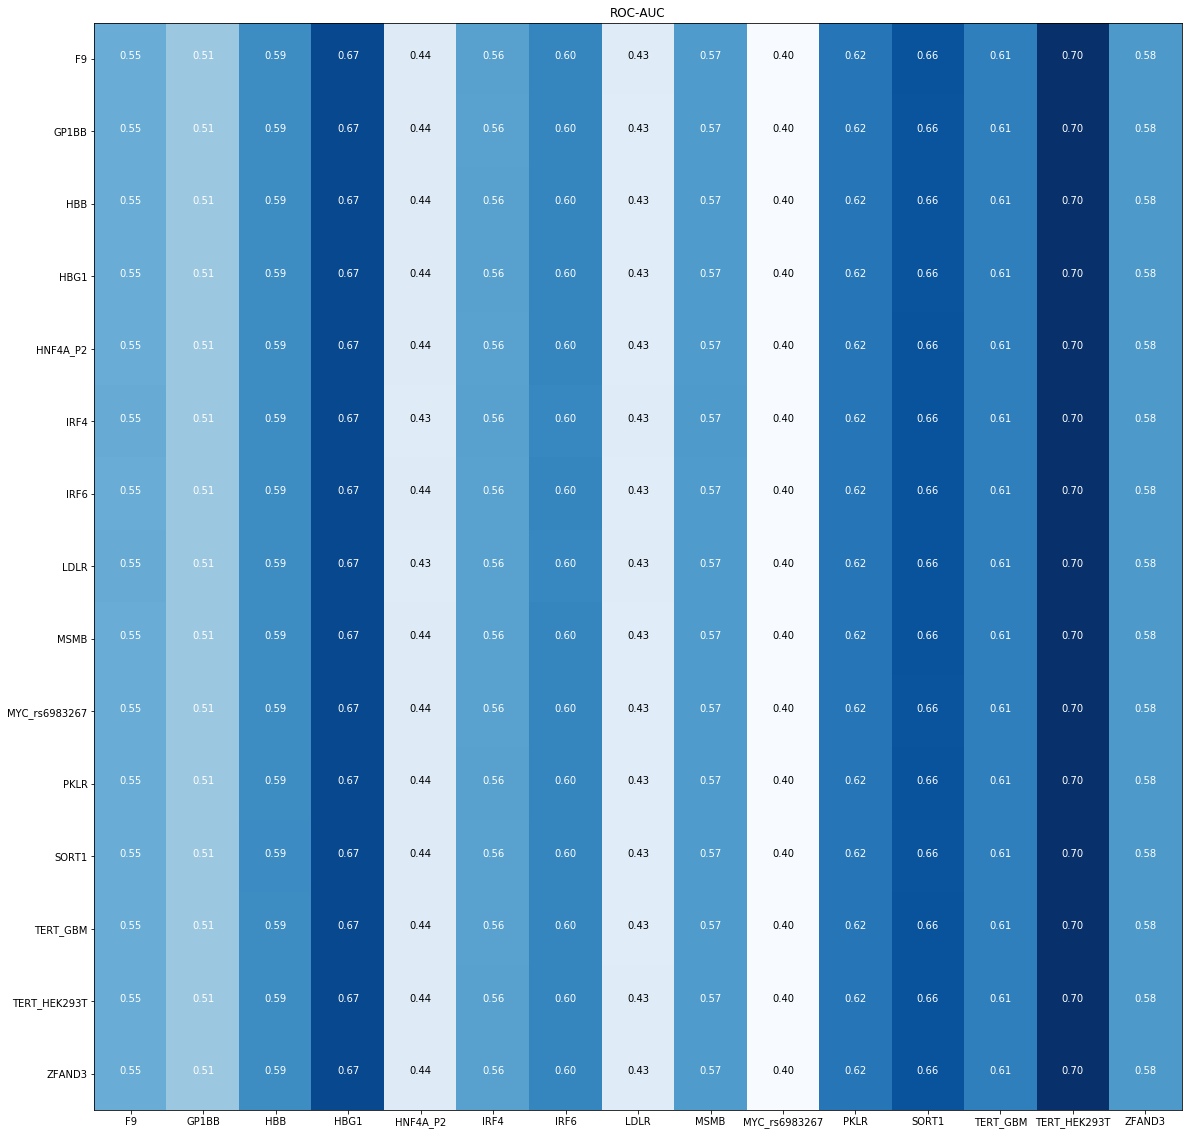

In [21]:
import itertools
plt.figure(figsize=(20,20))
plt.title("ROC-AUC")
plt.xticks(np.arange(num_constructions), CONSTRUCTONS)
plt.yticks(np.arange(num_constructions), CONSTRUCTONS)
plt.imshow(aucs, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(num_constructions), range(num_constructions)):
    plt.text(j, i, format(aucs[i][j], '.2f'),
        horizontalalignment="center",
            color="white" if aucs[i][j] > 0.5 else "black")

plt.show()

In [93]:
[cfg['weights_loss'] for cfg in ml_config]
# ml_config

[0.11572183675195882,
 0.5154114805347235,
 0.04529935758164583,
 1.021762889348099,
 0.04738610785195419,
 1.194922515086262,
 0.610678250629224,
 1.4774424039232996,
 0.3705836794565203,
 0.06828697799422084,
 0.5868893857506656,
 1.366796900448421,
 0.4530761724575708,
 0.07179945664025554,
 0.8020980987078631]

In [ ]:
train_construction = 'PKLR'
test_construction = 'F9'
train_data = FULL_DATA[ FULL_DATA['construction'] == train_construction]
train_feed_data = {
    pvals: train_data[motif_pval_feature_names],
    fcs: train_data[motif_fc_feature_names], 
    confs: train_data[['confidence']].as_matrix().flatten(),
#     confs: (1.0 * train_data[['confidence']] > 0.1).as_matrix().flatten(),
}

for i in range(50):
#     train_data_subset = train_data.sample(frac=0.5)
#     train_feed_data_subset = {
#         pvals: train_data_subset[motif_pval_feature_names],
#         fcs: train_data_subset[motif_fc_feature_names],
#         confs: train_data_subset[['confidence']].as_matrix().flatten(),
# #         confs: (1.0 * train_data_subset[['confidence']] > 0.1).as_matrix().flatten(),
#     }
    train_feed_data_subset = train_feed_data
    
    sess.run(train, feed_dict=train_feed_data_subset)
    last_step, lossval = sess.run((step_info, loss), feed_dict=train_feed_data)
    if True: #i % 500 == 0:
        print(round(lossval,3), *(round(last_step[el],3) for el in values_to_report), sep='\t\t')

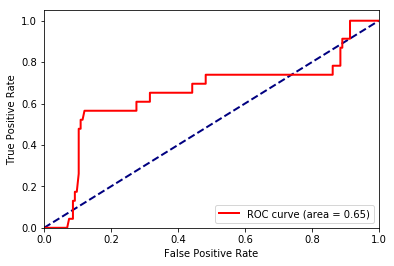

In [11]:
test_data = FULL_DATA[FULL_DATA['construction'] == test_construction]

test_feed_data = {
    pvals: test_data[motif_pval_feature_names],
    fcs: test_data[motif_fc_feature_names]
}
scores = sess.run(prediction, feed_dict=test_feed_data)
fpr, tpr, _ = sklearn.metrics.roc_curve(test_data['confidence'] > 0.1, scores)
roc_auc = sklearn.metrics.auc(fpr, tpr)
aucs[train_idx][test_idx] = roc_auc

In [ ]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title(label)
plt.plot(fpr, tpr, color='red', lw=2, 
            label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
#plt.scatter(confs_ds, last_step['prediction'])

In [12]:
np.mean(np.abs(1*(last_step['prediction'] > 0.5) - 1* (confs_ds > 0.1)))

0.2604166666666667

In [244]:
#plt.hist(last_step['thresholds'].flatten())
FULL_DATA[FULL_DATA['construction'] == 'IRF6'][motif_pval_feature_names].mean(axis=0).sort_values()

POU domain factors{3.1.10}:median_pval                                     0.939005
ARID-related factors{3.7.1}:median_pval                                    0.951583
bHLH-ZIP factors{1.2.6}:median_pval                                        0.970483
HD-LIM factors{3.1.5}:median_pval                                          0.979009
C/EBP-related{1.1.8}:median_pval                                           0.979872
Heteromeric CCAAT-binding factors{4.2.1}:median_pval                       0.994730
HOX-related factors{3.1.1}:median_pval                                     1.011853
PAS domain factors{1.2.5}:median_pval                                      1.021247
MyoD / ASC-related factors{1.2.2}:median_pval                              1.021487
E2A-related factors{1.2.1}:median_pval                                     1.024641
Fos-related factors{1.1.2}:median_pval                                     1.026671
Jun-related factors{1.1.1}:median_pval                                     1

In [30]:
import keras
# model = keras.models.Sequential([
#     keras.layers.Dense(32, input_shape=(784,)),
#     keras.layers.Activation('relu'),
#     keras.layers.Dense(10),
#     keras.layers.Activation('softmax'),
# ])

motif_pval_feature_names = feature_names_by_type(FULL_DATA, pval_feature_suffix)
motif_fc_feature_names = feature_names_by_type(FULL_DATA, fc_feature_suffix)

num_motifs = len(motif_pval_feature_names)
pvals_input = keras.layers.Input(shape=(num_motifs,), dtype='float64', name='pvals_input')
fc_input = keras.layers.Input(shape=(num_motifs,), dtype='float64', name='fc_input')

#     loss =  tf.square(tf.reduce_sum(weight * tf.sigmoid(pval - threshold) * tf.abs(fc), axis=1) - confidence) + \
#             C_0 * tf.reduce_sum(tf.square(weight - tf.ones(shape=(num_motifs), dtype=tf.float64))) + \
#             C_1 * tf.reduce_sum(tf.square(threshold - t_0 * tf.ones(shape=(num_motifs), dtype=tf.float64)))


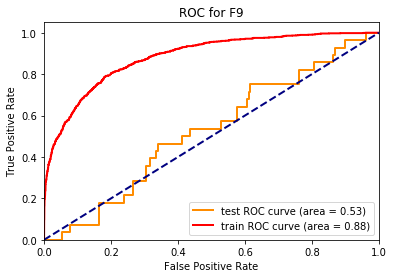

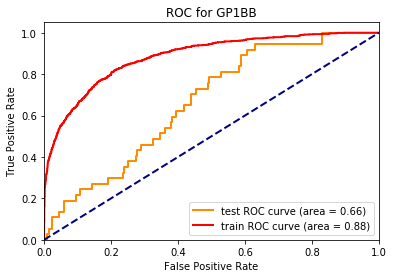

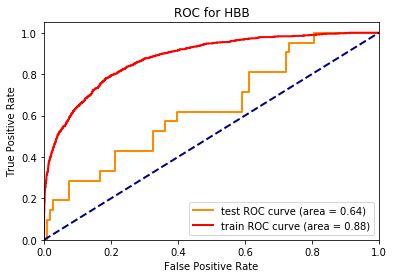

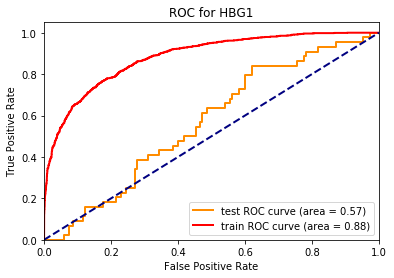

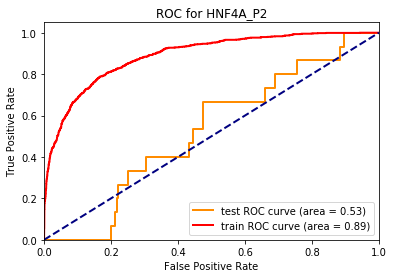

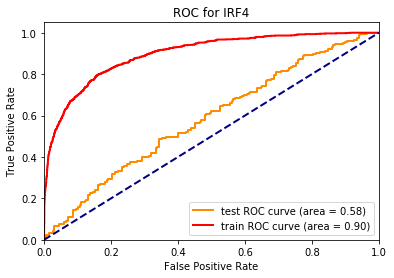

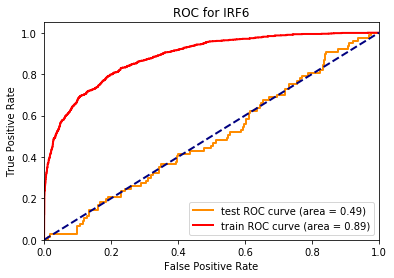

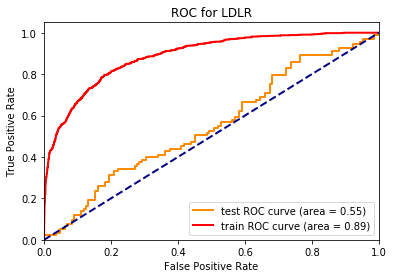

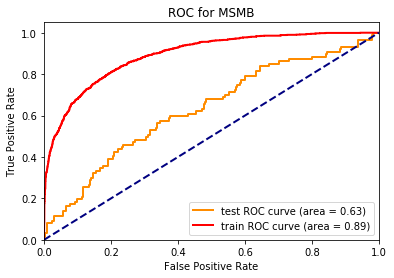

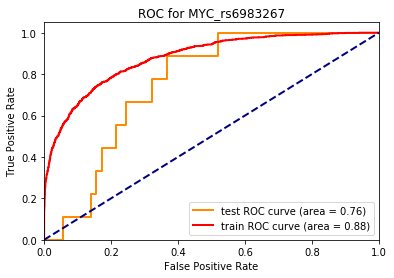

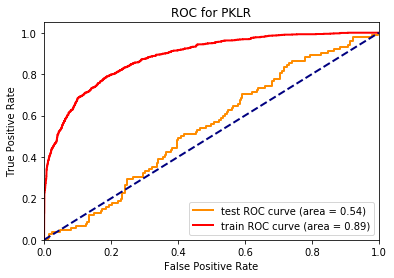

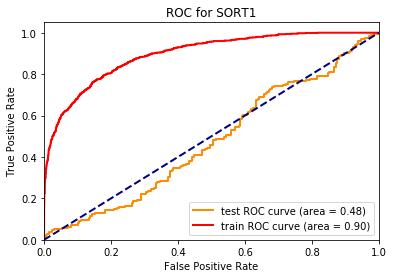

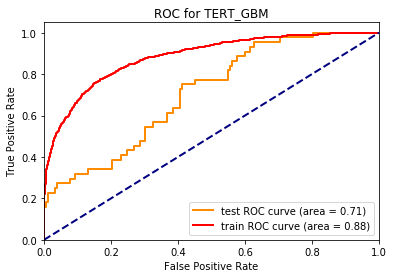

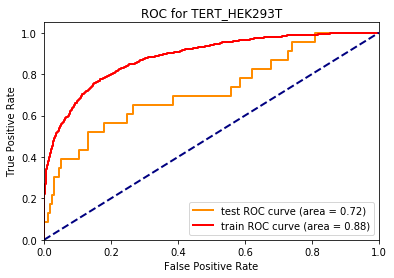

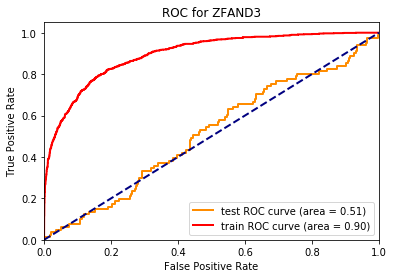

{'F9': {'test': 0.5253120665742026, 'train': 0.88274888412619212},
 'GP1BB': {'test': 0.66350812964358785, 'train': 0.88399774162802047},
 'HBB': {'test': 0.63800705467372132, 'train': 0.87958649040339476},
 'HBG1': {'test': 0.56741400491400484, 'train': 0.88312310579969688},
 'HNF4A_P2': {'test': 0.52592592592592591, 'train': 0.89027513326517305},
 'IRF4': {'test': 0.58387150190428883, 'train': 0.89743583258639681},
 'IRF6': {'test': 0.49247343565525381, 'train': 0.88620450034760723},
 'LDLR': {'test': 0.55077658303464749, 'train': 0.88827428165332667},
 'MSMB': {'test': 0.63235049142095623, 'train': 0.89253243996829235},
 'MYC_rs6983267': {'test': 0.75646149746869173, 'train': 0.87989117748491374},
 'PKLR': {'test': 0.54109303295786404, 'train': 0.88502760600566821},
 'SORT1': {'test': 0.47593073593073593, 'train': 0.89542920386494729},
 'TERT_GBM': {'test': 0.70870469399881164, 'train': 0.88348920719526502},
 'TERT_HEK293T': {'test': 0.72288855572213895, 'train': 0.88348920719526502

In [6]:
test_feature_subset(FULL_DATA, ['median_pval', 'median_abs_fc'], constructions_to_test=CONSTRUCTONS,
                        plot=True,
                        classifierBuilder=lambda:sklearn.svm.LinearSVC(),
                        useRegression=False)

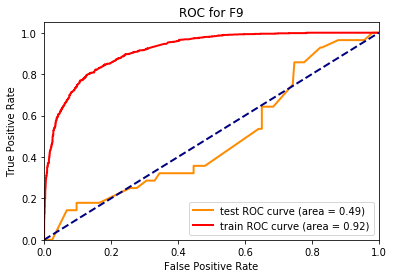

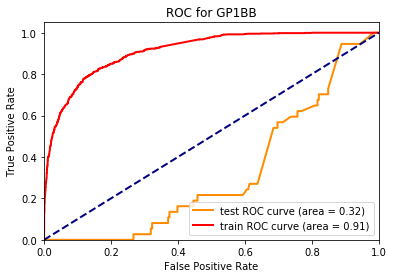

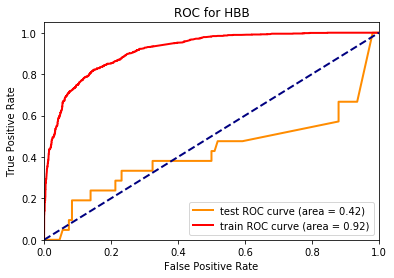

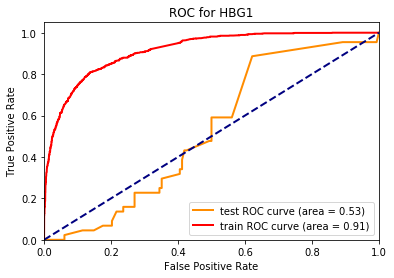

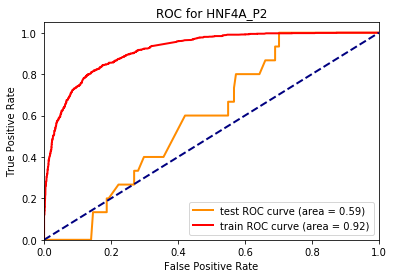

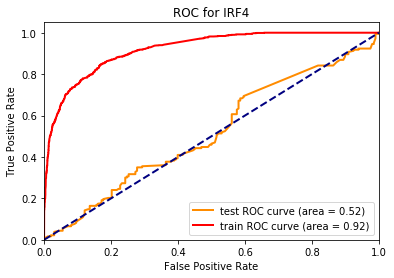

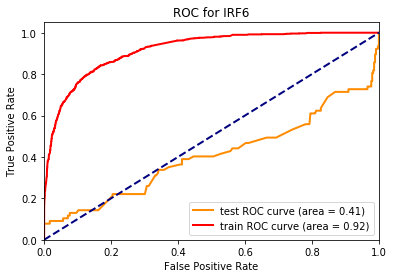

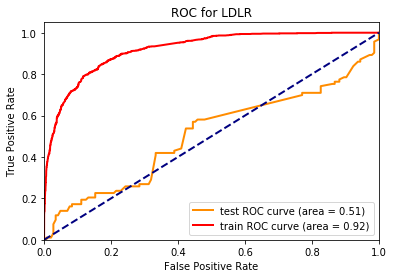

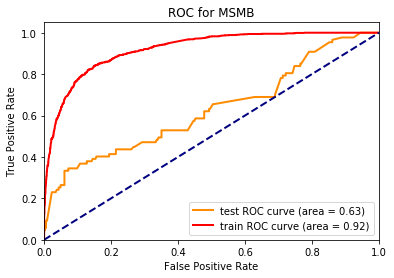

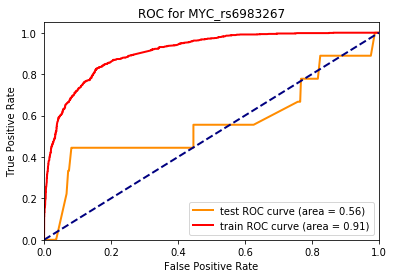

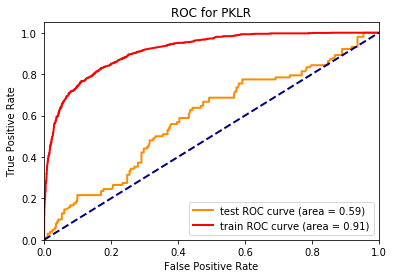

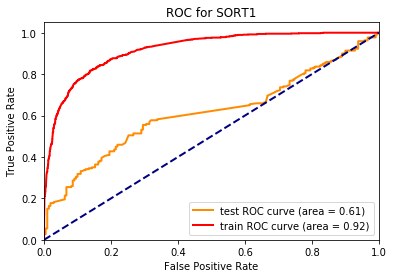

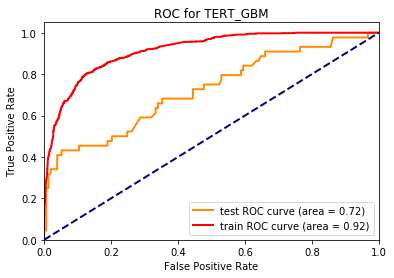

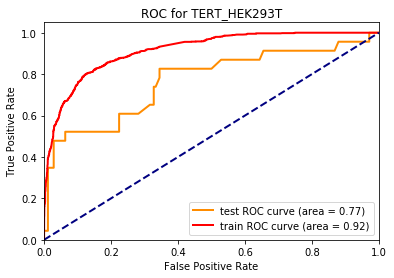

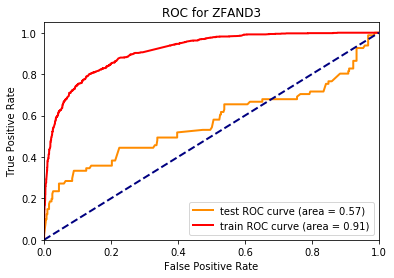

{'F9': {'test': 0.48803744798890425, 'train': 0.91757323029657756},
 'GP1BB': {'test': 0.3213093571659309, 'train': 0.91392763628337348},
 'HBB': {'test': 0.42129629629629634, 'train': 0.91676140651077731},
 'HBG1': {'test': 0.52648955773955775, 'train': 0.91430135578821703},
 'HNF4A_P2': {'test': 0.59083820662768027, 'train': 0.91624796973076128},
 'IRF4': {'test': 0.51740078379422649, 'train': 0.92088458194821288},
 'IRF6': {'test': 0.40757821723730819, 'train': 0.91843545796474968},
 'LDLR': {'test': 0.50616039426523296, 'train': 0.91901804373618567},
 'MSMB': {'test': 0.62918540729635175, 'train': 0.92068539439096742},
 'MYC_rs6983267': {'test': 0.56021849187316808, 'train': 0.91002112897711951},
 'PKLR': {'test': 0.5895911556111807, 'train': 0.91442534152771815},
 'SORT1': {'test': 0.61360389610389621, 'train': 0.91959589879241599},
 'TERT_GBM': {'test': 0.7228163992869876, 'train': 0.91531545516995849},
 'TERT_HEK293T': {'test': 0.76849075462268868, 'train': 0.91531545516995849},

In [5]:
test_feature_subset(FULL_DATA, [pval_feature_suffix, fc_feature_suffix], constructions_to_test=CONSTRUCTONS,
                        plot=True,
                        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
                        useRegression=False)

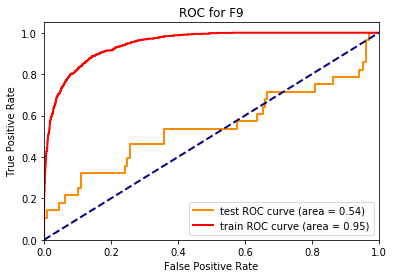

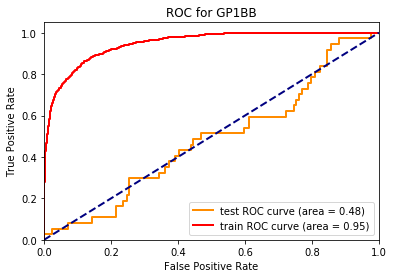

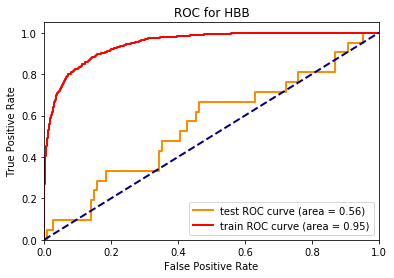

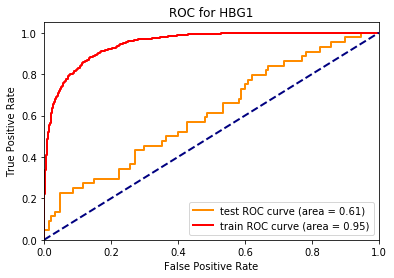

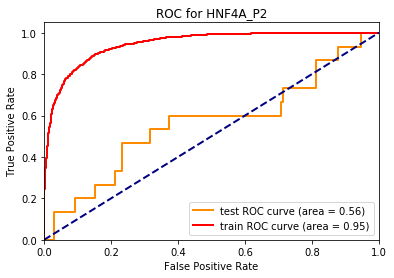

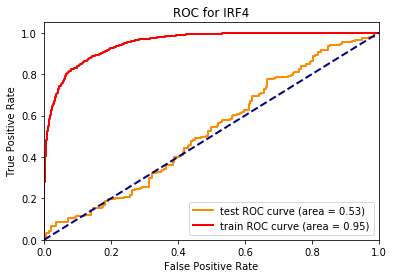

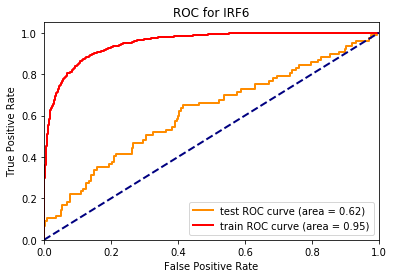

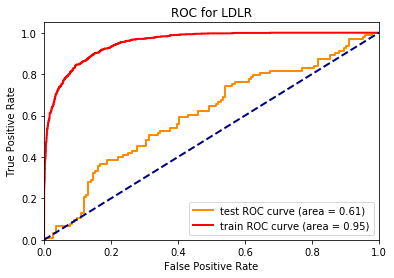

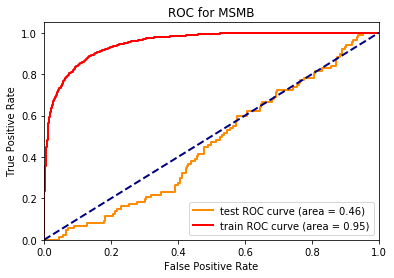

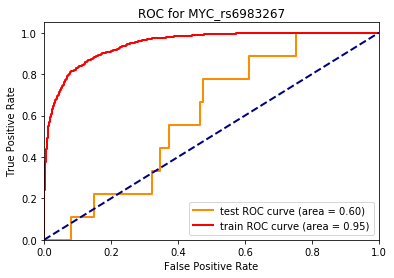

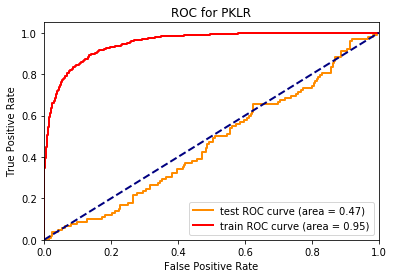

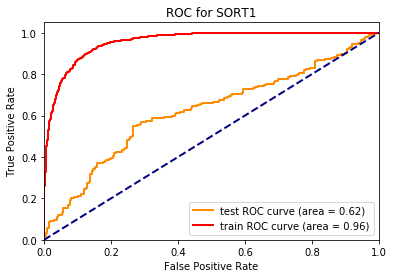

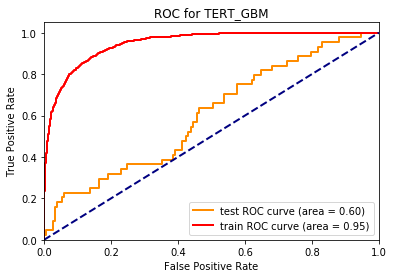

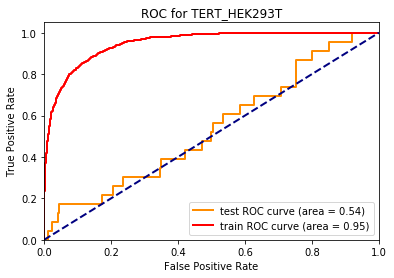

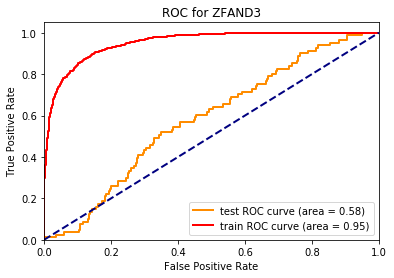

{'F9': {'test': 0.54351595006934805, 'train': 0.94779898059379897},
 'GP1BB': {'test': 0.48153332615484018, 'train': 0.94746052184146079},
 'HBB': {'test': 0.55687830687830686, 'train': 0.94722310997478798},
 'HBG1': {'test': 0.61025798525798525, 'train': 0.94863158378105339},
 'HNF4A_P2': {'test': 0.56374269005847955, 'train': 0.94610532479110099},
 'IRF4': {'test': 0.52591488657062424, 'train': 0.95072343249548286},
 'IRF6': {'test': 0.61717827626918542, 'train': 0.95088706105902243},
 'LDLR': {'test': 0.60700418160095593, 'train': 0.95302079004583207},
 'MSMB': {'test': 0.46280193236714973, 'train': 0.95087509773564904},
 'MYC_rs6983267': {'test': 0.60298427924327203, 'train': 0.94604897163777446},
 'PKLR': {'test': 0.46676401056876654, 'train': 0.95134298973421472},
 'SORT1': {'test': 0.62188311688311693, 'train': 0.95681502174668709},
 'TERT_GBM': {'test': 0.60071301247771847, 'train': 0.94900890499735235},
 'TERT_HEK293T': {'test': 0.53873063468265869, 'train': 0.9490089049973523

In [6]:
test_feature_subset(FULL_DATA, ['family_expression','median_pval', 'median_abs_fc', 'stddev_pval', 'stddev_abs_fc'], constructions_to_test=CONSTRUCTONS,
                        plot=True,
                        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
                        useRegression=False)

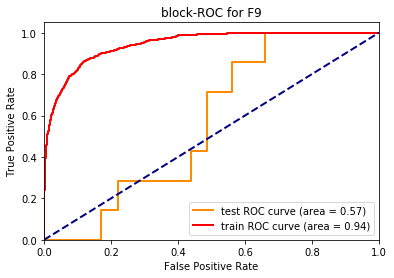

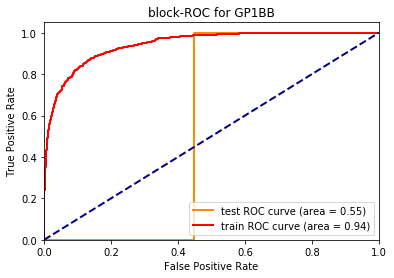

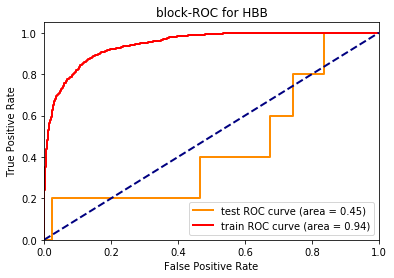

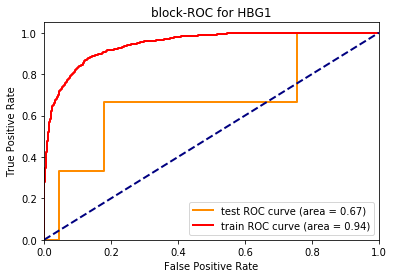

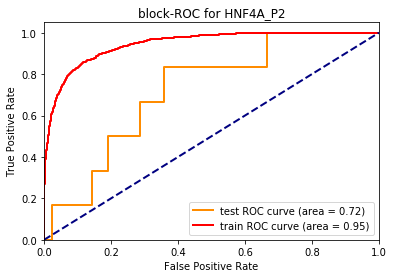

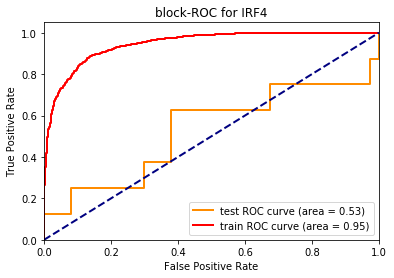

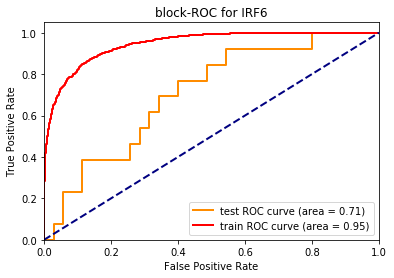

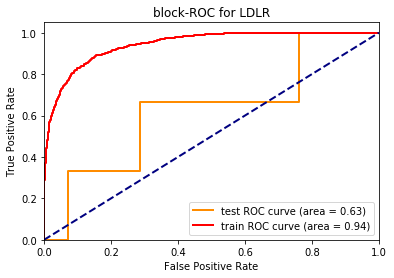

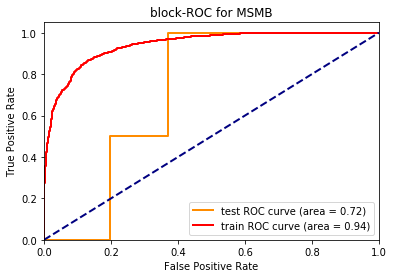

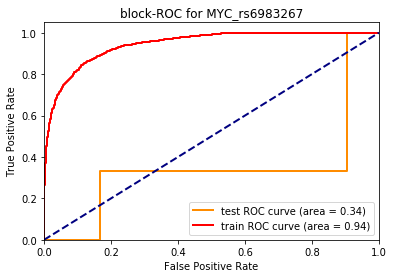

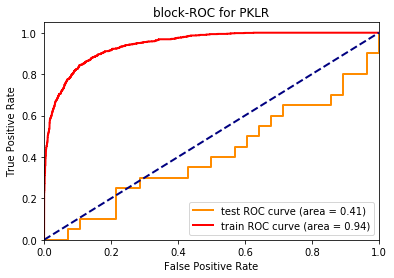

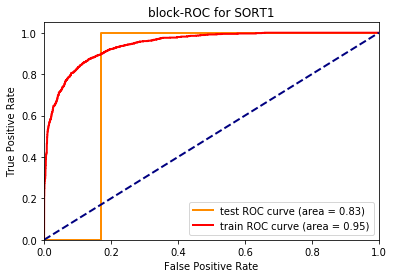

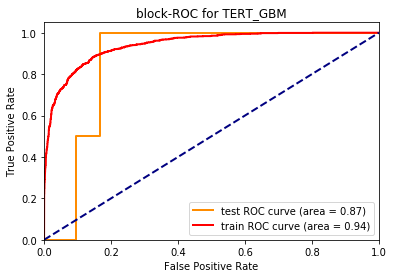

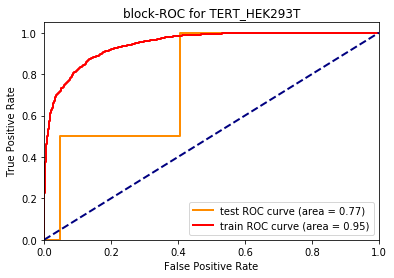

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


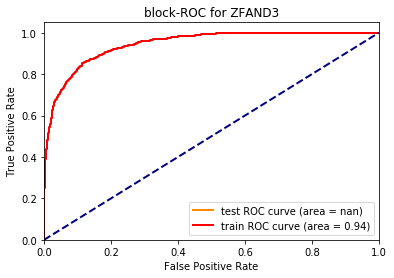

{'F9': {'test': 0.56794425087108014, 'train': 0.94489543105168339},
 'GP1BB': {'test': 0.55319148936170215, 'train': 0.94385207610073474},
 'HBB': {'test': 0.45116279069767445, 'train': 0.94468934403829286},
 'HBG1': {'test': 0.67407407407407394, 'train': 0.94497328224136168},
 'HNF4A_P2': {'test': 0.72222222222222221, 'train': 0.94502768984369379},
 'IRF4': {'test': 0.52702702702702697, 'train': 0.94534586007509169},
 'IRF6': {'test': 0.70769230769230773, 'train': 0.94538685713777293},
 'LDLR': {'test': 0.62698412698412698, 'train': 0.9433957871379095},
 'MSMB': {'test': 0.71739130434782605, 'train': 0.94143169002247262},
 'MYC_rs6983267': {'test': 0.34126984126984128, 'train': 0.94373350545728185},
 'PKLR': {'test': 0.40892857142857142, 'train': 0.94438688107869151},
 'SORT1': {'test': 0.82978723404255317, 'train': 0.94532817485611487},
 'TERT_GBM': {'test': 0.86904761904761907, 'train': 0.94215816145245801},
 'TERT_HEK293T': {'test': 0.77380952380952384, 'train': 0.94599786216753834

In [3]:
test_feature_subset_by_blocks(FULL_DATA, 'all', constructions_to_test=CONSTRUCTONS,
                        plot=True,
                        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
                        useRegression=False)

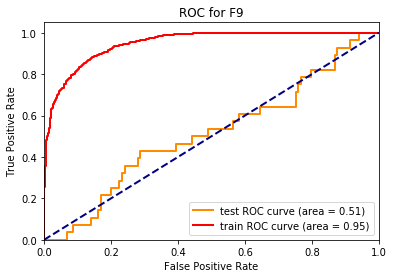

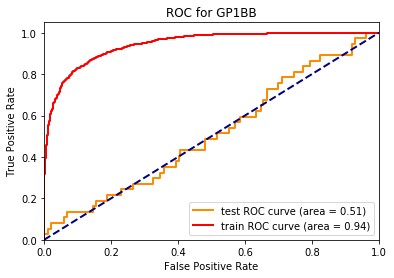

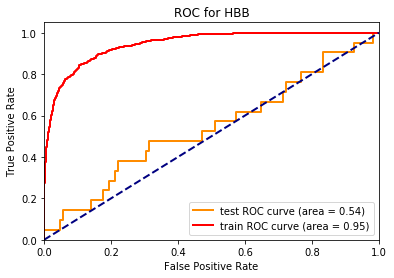

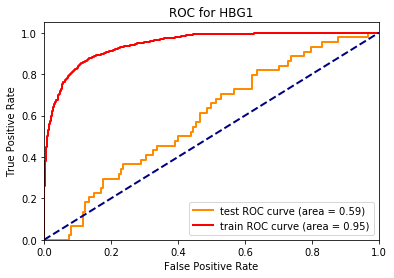

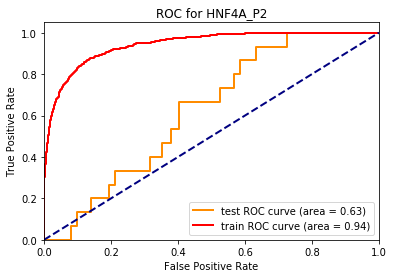

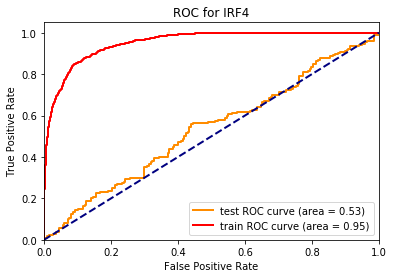

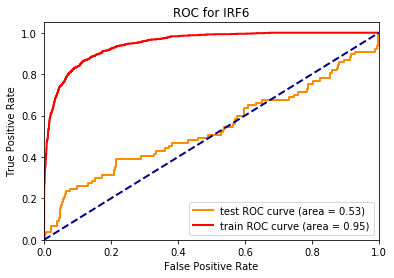

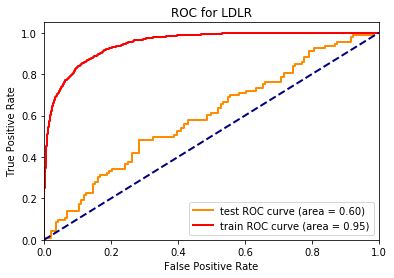

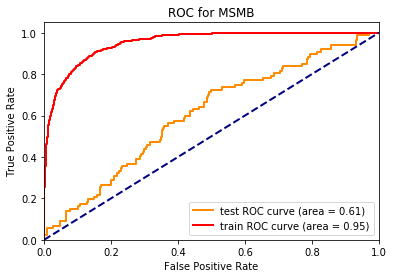

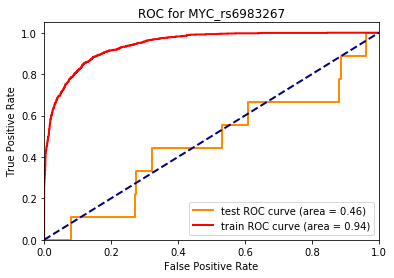

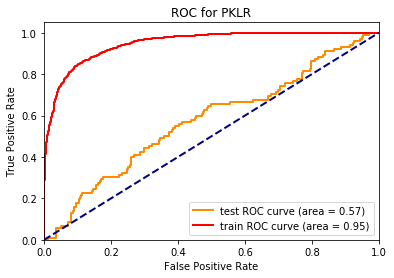

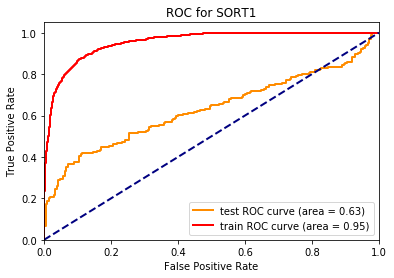

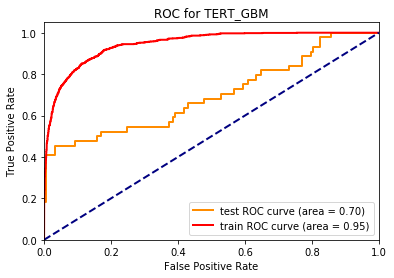

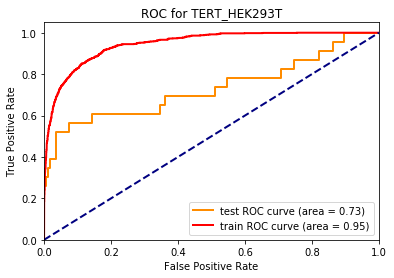

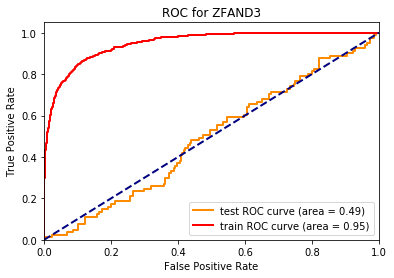

{'F9': {'test': 0.51178918169209431, 'train': 0.94859046913841416},
 'GP1BB': {'test': 0.51049854635512004, 'train': 0.94410264835555302},
 'HBB': {'test': 0.54056437389770717, 'train': 0.94535550051489659},
 'HBG1': {'test': 0.58753071253071254, 'train': 0.94509631721541076},
 'HNF4A_P2': {'test': 0.6257309941520468, 'train': 0.94236437548623198},
 'IRF4': {'test': 0.53292487718717241, 'train': 0.95181669131725899},
 'IRF6': {'test': 0.53457054309327035, 'train': 0.94794675110180782},
 'LDLR': {'test': 0.59647550776583036, 'train': 0.94923091284682704},
 'MSMB': {'test': 0.60659670164917534, 'train': 0.9518563493433787},
 'MYC_rs6983267': {'test': 0.46496136424193973, 'train': 0.94391408653694098},
 'PKLR': {'test': 0.57478097622027535, 'train': 0.94867804099979613},
 'SORT1': {'test': 0.63121212121212122, 'train': 0.95421326166393949},
 'TERT_GBM': {'test': 0.69919786096256686, 'train': 0.9454264864410965},
 'TERT_HEK293T': {'test': 0.73238380809595205, 'train': 0.9454264864410965},


In [13]:
test_feature_subset(FULL_DATA, 'all', constructions_to_test=CONSTRUCTONS,
                        plot=True,
                        classifierBuilder=lambda:xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1),
                        useRegression=False)

In [ ]:
calc_auc_by_blocks(
    train_base=empty_dataframe(FULL_DATA),
    block_data=select_data_by(FULL_DATA,'construction', ['F9']),
    plot = True, filename = None, label = 'ROC')


In [ ]:
calc_auc_by_blocks(
    train_base=reject_data_by(FULL_DATA,'construction', ['F9']),
    block_data=select_data_by(FULL_DATA,'construction', ['F9']),
    plot = True, filename = None, label = 'ROC')


In [ ]:
calc_auc(
    train_data=reject_data_by(FULL_DATA,'construction', ['F9']),
    test_data=select_data_by(FULL_DATA,'construction', ['F9']),
    plot = True, filename = None, label = 'ROC')


In [3]:
stable_feature_importances(select_data_by(FULL_DATA,'construction', ['F9']), num_rounds=3)

...

array([ 0.00038432,  0.00737795,  0.00042159, ...,  0.00361405,
        0.        ,  0.        ])